In [20]:
import os
import wave
import shutil
import librosa
import pathlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
import pickle
from scipy.io import wavfile

%matplotlib inline
matplotlib.style.use('ggplot')

### config

In [2]:
fe_dir_name = 'logmel+delta_nmels128_duration2_nfft2560'

In [3]:
inter_dir = pathlib.Path('../data/interim/')
fe_dir = inter_dir / fe_dir_name
fe_dir

PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560')

### Loading data

In [4]:
data_dir = '../data/input/'
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [6]:
train_curated["nframe"] = train_curated["fname"].apply(
    lambda f: wave.open(data_dir + "train_curated/" + f).getnframes()
)
train_noisy["nframe"] = train_noisy["fname"].apply(
    lambda f: wave.open(data_dir + "train_noisy/" + f).getnframes()
)
test["nframe"] = test["fname"].apply(
    lambda f: wave.open(data_dir + "test/" + f).getnframes()
)

In [7]:
train = pd.concat([train_curated, train_noisy], axis=0, sort=False, ignore_index=True)
train['noisy_flg'] = 0
train.loc[len(train_curated):len(train_curated) + len(train_noisy), 'noisy_flg'] = 1
train['n_labels'] = train['labels'].apply(lambda x: len(x.split(',')))

total = pd.concat([train, test[['fname', 'nframe']]], axis=0, sort=False, ignore_index=True)
total['test_flg'] = 0
total.loc[len(train):len(train) + len(test), 'test_flg'] = 1
total.head()

fname           labels   nframe  noisy_flg  n_labels  test_flg
0  0006ae4e.wav             Bark   310456        0.0       1.0         0
1  0019ef41.wav         Raindrop    90616        0.0       1.0         0
2  001ec0ad.wav  Finger_snapping    66976        0.0       1.0         0
3  0026c7cb.wav              Run  1125886        0.0       1.0         0
4  0026f116.wav  Finger_snapping    60638        0.0       1.0         0

In [8]:
def load_data(filename):
    return pickle.load(open(filename, "rb"), encoding='latin1')

fe_list = list(pathlib.Path(fe_dir).glob("*.pkl"))
len(fe_list), fe_list[:3]

(133065,
 [PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/fe5bad8c.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/04b781ac_aug7.pkl'),
  PosixPath('../data/interim/logmel+delta_nmels128_duration2_nfft2560/3315ec7f_aug5.pkl')])

### check features

In [23]:
fname = 'e140e930.wav'

In [24]:
fname_record = total.query('fname == @fname')
noisy_flg = fname_record["noisy_flg"].values[0]
test_flg = fname_record["test_flg"].values[0]

if test_flg == 1:
    wav_dir = data_dir + 'test/'
else:
    if noisy_flg == 0:
        wav_dir = data_dir + 'train_curated/'
    else:
        wav_dir = data_dir + 'train_noisy/'

print(wav_dir)
display(fname_record)
ipd.Audio(wav_dir + fname)

../data/input/train_noisy/


fname     labels  nframe  noisy_flg  n_labels  test_flg
22435  e140e930.wav  Gasp,Sigh  661500        1.0       2.0         0

(3, 128, 1376)


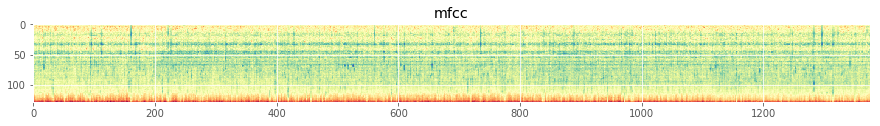

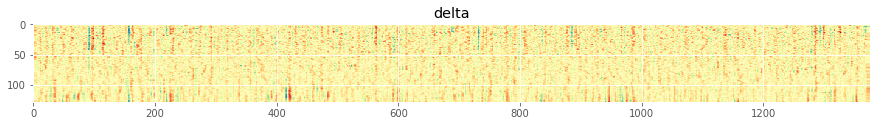

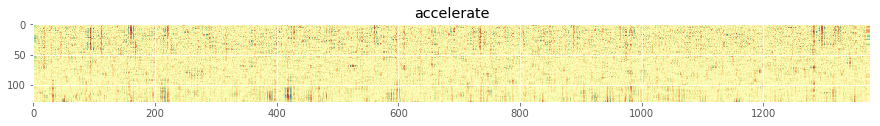

In [12]:
p_name = os.path.splitext(fname)[0] + '.pkl'
fe = load_data(fe_dir / p_name)
print(fe.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

(3, 128, 1147)


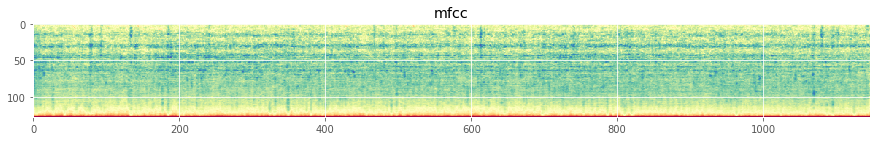

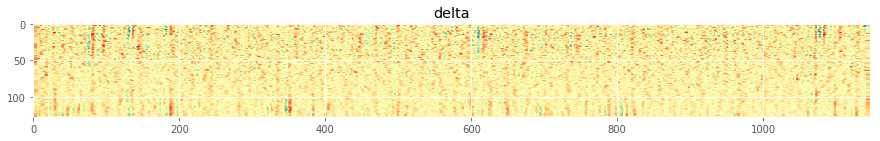

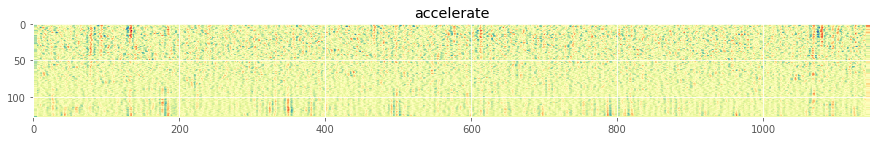

In [21]:
p_name = os.path.splitext(fname)[0] + '_aug12.pkl'
fe = load_data(fe_dir / p_name)
print(fe.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

### check augmentation（specAugment）

In [13]:
def standarize(X, eps=1e-6):
    """ X is 2d-array. X.shape = (xx, yy)
    """
    max_ = X.max()
    min_ = X.min()
    if (max_ - min_) > eps:
        # normalize to [0, 255]
        # X = (X - min_) / (max_ - min_) * 255
        # normalize to [0, 1]
        X = (X - min_) / (max_ - min_)
    else:
        # just zero
        X = np.zeros_like(X)

    # X = X.astype(np.uint8)
    return X

fe_sc = fe.copy()
for i in range(3):
    fe_sc[i, :, :] = standarize(fe[i, :, :])

(3, 128, 448)


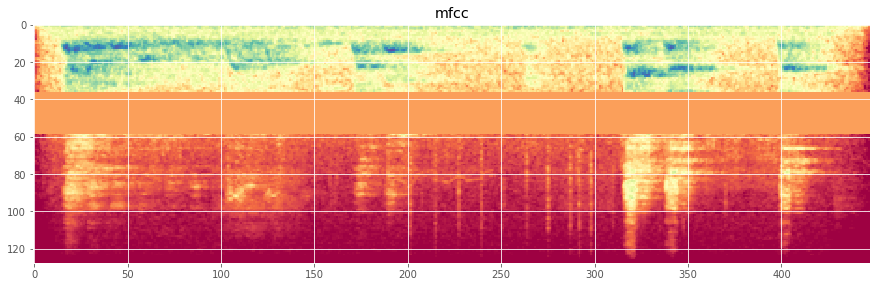

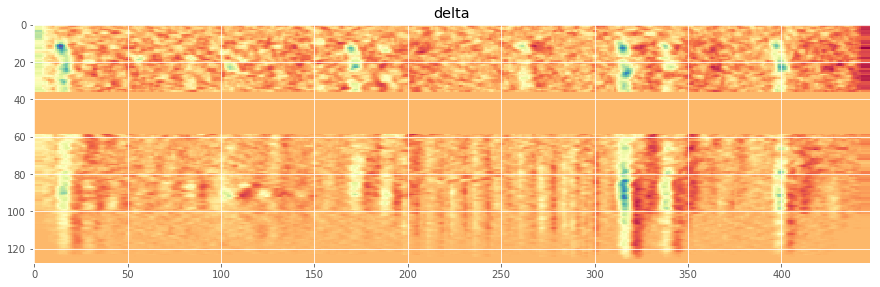

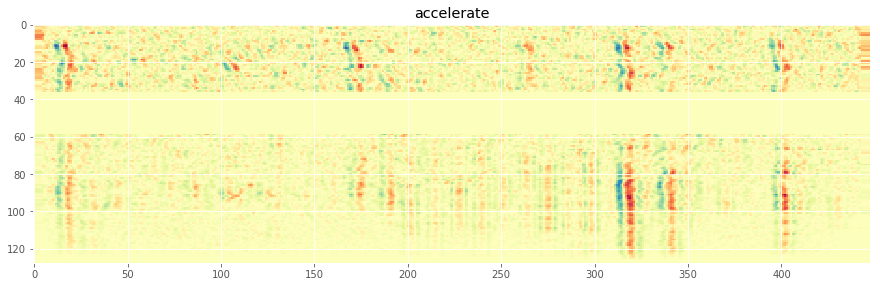

In [24]:
import random
import torch
def freq_mask(data, F=30, num_masks=1, replace_with_zero=False):
    spec = data.copy()   # data.shape = (3, n_mel, xx)
    num_mel_channels = spec.shape[1]

    mask_value_list = []
    for i_channel in range(spec.shape[0]):
        mask_value_list.append(spec[i_channel].mean())

    for i in range(num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        if f_zero == f_zero + f:
            # avoids randrange error if values are equal and range is empty
            return spec

        mask_end = random.randrange(f_zero, f_zero + f)
        if replace_with_zero:
            for i_channel in range(spec.shape[0]):
                spec[i_channel, f_zero:mask_end, :] = 0
        else:
            for i_channel in range(spec.shape[0]):
                # mask_value = np.random.rand()
                mask_value = mask_value_list[i_channel]
                spec[i_channel, f_zero:mask_end, :] = mask_value

    return spec


fe_freq_mask = freq_mask(fe_sc, F=40, num_masks=2, replace_with_zero=False)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

(3, 128, 448)


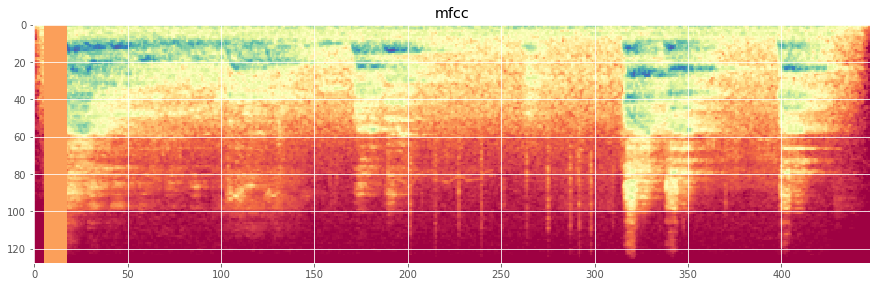

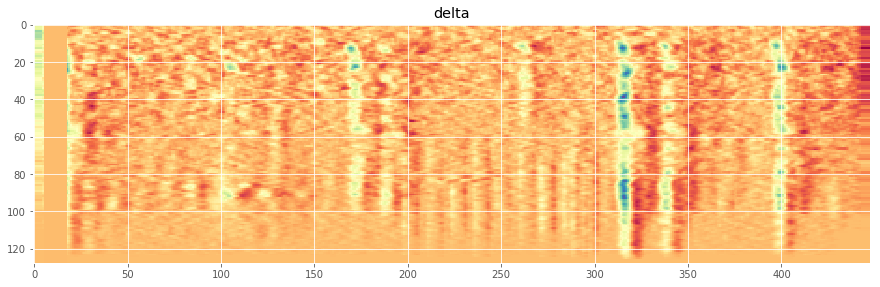

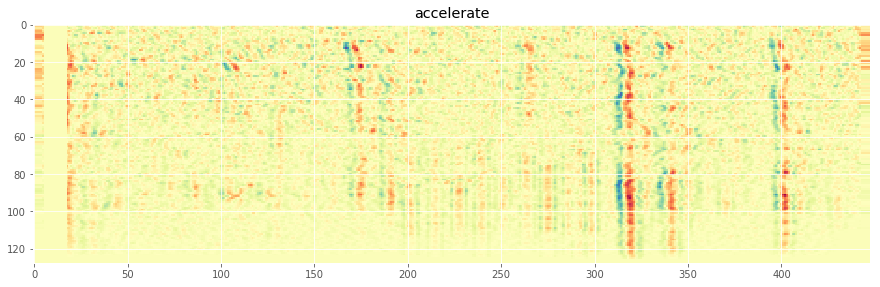

In [23]:
def time_mask(data, T=30, num_masks=1, replace_with_zero=False):
    spec = data.copy()   # data.shape = (3, n_mel, xx)
    len_spectro = spec.shape[2]

    mask_value_list = []
    for i_channel in range(spec.shape[0]):
        mask_value_list.append(spec[i_channel].mean())

    for i in range(num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        if t_zero == t_zero + t:
            # avoids randrange error if values are equal and range is empty
            return spec

        mask_end = random.randrange(t_zero, t_zero + t)
        if replace_with_zero:
            for i_channel in range(spec.shape[0]):
                spec[i_channel, :, t_zero:mask_end] = 0
        else:
            for i_channel in range(spec.shape[0]):
                # mask_value = np.random.rand()
                mask_value = mask_value_list[i_channel]
                spec[i_channel, :, t_zero:mask_end] = mask_value

    return spec

fe_freq_mask = time_mask(fe_sc, T=20, num_masks=2, replace_with_zero=False)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");

(3, 128, 448)


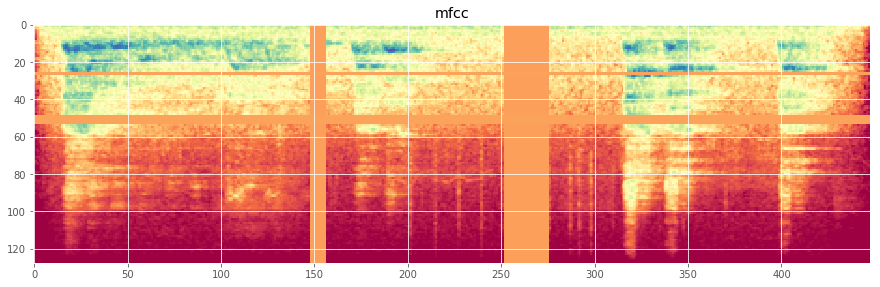

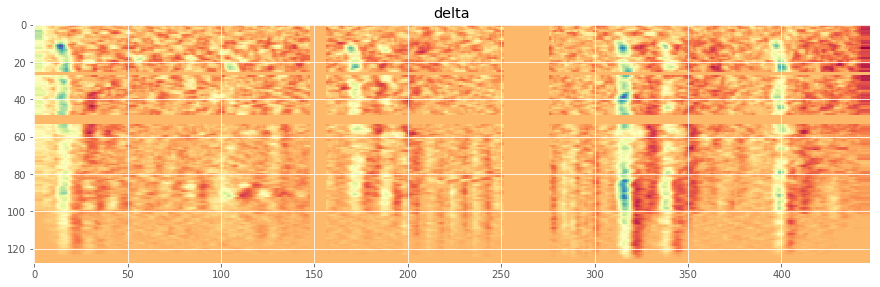

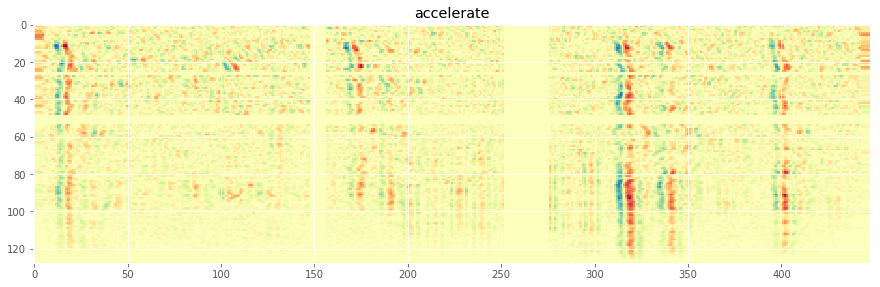

In [34]:
fe_freq_mask = freq_mask(time_mask(fe_sc, T=40, num_masks=2, replace_with_zero=False), F=40, num_masks=2)
print(fe_freq_mask.shape)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[0, :, :], cmap='Spectral', interpolation='nearest')
plt.title("mfcc")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[1, :, :], cmap='Spectral', interpolation='nearest')
plt.title("delta")
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(fe_freq_mask[2, :, :], cmap='Spectral', interpolation='nearest')
plt.title("accelerate");